# `eeg-01`: Preprocessing
This demo implements EEG preprocessing using bandpass filtering and independent component analysis (ICA). ICA-based preprocessing will allow us to identify and remove noise signals due to eyeblinks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

### Example raw data
Similar to fMRI, EEG data come in a variety of different file formats. We will use the Elektra Neuromag (fif) file format, typically associated with MEG data, as that is the native data type to MNE. For loading different file formats into MNE, see this [tutorial](https://mne.tools/stable/auto_tutorials/io/index.html).

In [2]:
from mne.io import read_raw_fif

# Specify path to raw data
raw_fn = '../eeg-data/sub-01_task-audvis_raw.fif'

# Load raw data
data_raw = read_raw_fif(raw_fn, preload=True, verbose=False)
print(data_raw)

<Raw | sub-01_task-audvis_raw.fif, 70 x 166800 (277.7 s), ~92.1 MB, data loaded>


### Inspecting the raw data
The `mne.io.Raw` class object is a very helpful data structure, containing the entire EEG recording and its corresponding metadata. The `.info` attribute allows us to easily inspect all of the metadata. We can also specify that channel `EEG 053` is a bad channel. Finally, we'll visualize the channel layout.

<Info | 20 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 70
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>


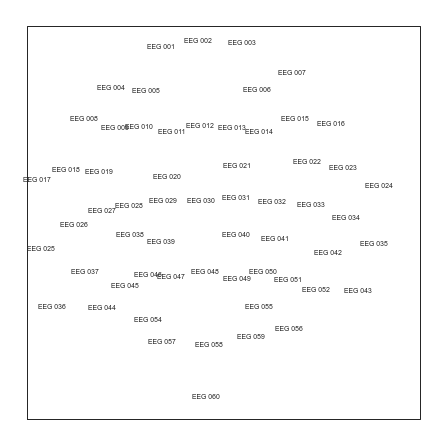

In [3]:
# Inspect metadata
print(data_raw.info)

# Designate bad channel
data_raw.info['bads'] = ['EEG 053']

# Visualize channel layout
from mne.channels import find_layout
from mne.viz import plot_layout

layout = find_layout(data_raw.info)
plot_layout(layout);

### Filtering

Filtering data can help remove high-frequency artifacts (e.g. EMG artifact) and low-frequency drifts, and notch filters at 50 Hz or 60 Hz help attenuate electrical line noise. Applying a high-pass filter at 0.1 Hz or 0.5 Hz to the continuous data is useful and recommended to minimize slow drifts. More conservative high-pass filters have the potential to [distort and bias EEG analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4506207/).

In [4]:
from mne import pick_types

# Select EEG channels (excluding other channels)
picks = pick_types(data_raw.info, meg=False, eeg=True, eog=False, stim=False)

# Apply bandpass filter
data_filtered = data_raw.filter(0.5, 40, picks=picks, method='fir', phase='zero')

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3965 samples (6.602 sec)



### Independent component analysis (ICA)

There are many sources of artifact in EEG data, including head motion, muscle tension, recording drift, and channel pops. Perhaps the most common source of artifact is eyeblink. Oculomotor activity causes large deflections in the EEG recording (with decreasing magnitude in channels further from the eyes). There are a number of methods for removing eyeblinks, including amplitude rejection, signal space projection (SSP), and independent component analysis (ICA). ICA finds directions in the feature space corresponding to projections with high non-Gaussianity. We thus obtain a decomposition into independent components, and the artifact's contribution is typically localized in only a small number of components. These components must be correctly identified and removed. More complete information about the theory behind ICA and its application with MNE can be found [here](https://mne.tools/stable/auto_tutorials/preprocessing/plot_40_artifact_correction_ica.html). 

In [5]:
from mne.preprocessing import ICA

# Define parameters for ICA
n_components = 25            # if float, select n_components by explained variance of PCA
method = 'fastica'
decim = 3 

# Initialize MNE's ICA object
ica = ICA(n_components=n_components, method=method, random_state=47404)

# Fit ICA to filtered data
picks = pick_types(data_filtered.info, meg=False, eeg=True, eog=False, stim=False)
ica.fit(data_filtered, picks=picks, decim=decim)
print(ica)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 0.8s.
<ICA | raw data decomposition, method: fastica (fit in 35 iterations on 55600 samples), 25 ICA components explaining 99.0 % of variance (59 PCA components available), channel types: eeg, no sources marked for exclusion>


We can visualize the scalp topography of each component to identify artifactual-looking components.

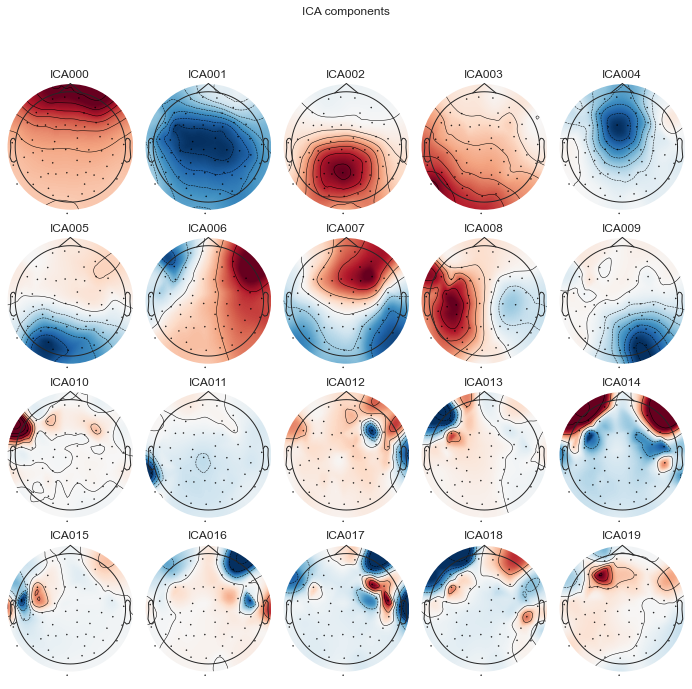

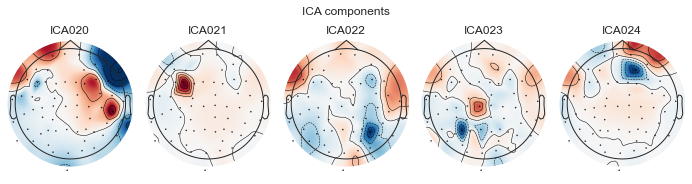

In [6]:
ica.plot_components();

MNE also has some nice functions for visually exploring features of each component. Unfortunately, because eyeblinks are often irregular in their onset, these metrics may not be particularly helpful.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


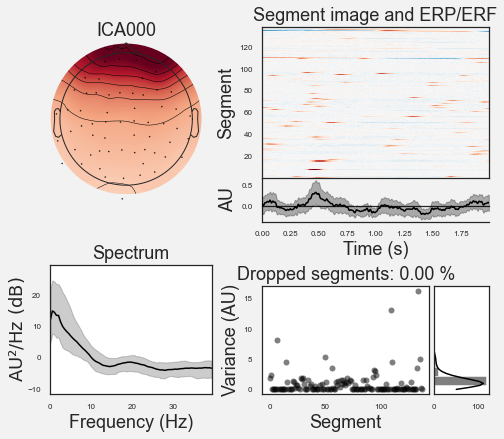

In [7]:
ica.plot_properties(data_filtered, picks=0, psd_args={'fmax': 40.});

There's a much more efficient way to detect artifactual components with MNE. Instead, we will take snapshots of each instance of a blink and correlate these data with the ICA components in order to find those components most likely corresponding to eyeblinks.

To identify eyeblinks in the data, we will use the `create_eog_epochs` function, which conveniently looks for large events in the EOG channel.

Using EOG channel: EOG 061
EOG channel index for this subject is: [69]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Now detecting blinks and generating corresponding events
Found 46 significant peaks
Number of EOG events detected: 46
Not setting metadata
46 matching events found
No baseline correction applied
Using data from preloaded Raw for 46 events and 601 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005'

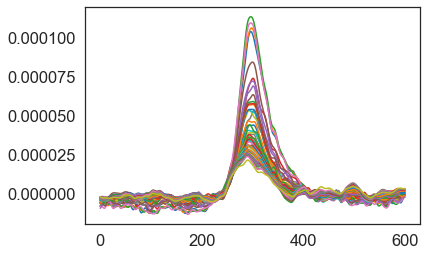

In [8]:
from mne.preprocessing import create_eog_epochs

# Identify eyeblink events
reject = dict(eeg=200e-6)
picks = pick_types(data_filtered.info, meg=False, eeg=True, eog=True, stim=False)
eog_epochs = create_eog_epochs(data_filtered, ch_name='EOG 061', picks=picks, reject=reject)

# Compute average eyeblink and plot
eog_average = eog_epochs.average()
plt.plot(eog_average.data.T);

Next we detect EOG related components using correlation. Detection is based on Pearson correlation between the filtered data and the filtered EOG channel. Thresholding is based on adaptive z-scoring. The above threshold components will be masked and the z-score will be recomputed until no supra-threshold component remains.

Using EOG channel: EOG 061


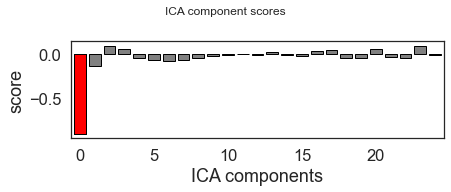

In [9]:
# Detect EOG components using correlation
eog_inds, scores = ica.find_bads_eog(eog_epochs)

# Plot correlation scores
ica.plot_scores(scores, exclude=eog_inds);

We can also inspect the source timecourse within the time window of our EOG average.

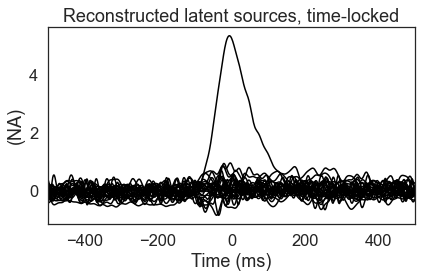

In [10]:
# Plot source reconstruction
ica.plot_sources(eog_average);

We can take a look at the properties of that component, now using the data epoched with respect to EOG events. 

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


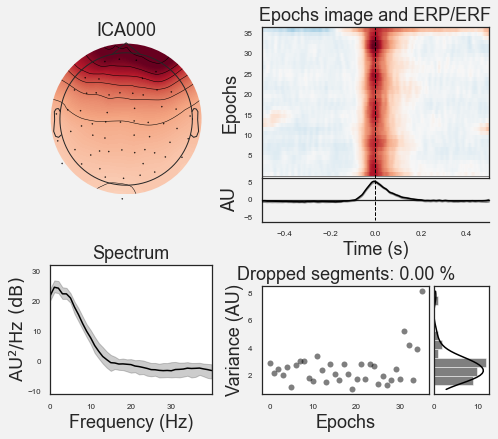

In [11]:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 40.}, image_args={'sigma': 1.});

Now let’s see how we would modify our signals if we removed this component from the data.

Applying ICA to Evoked instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components


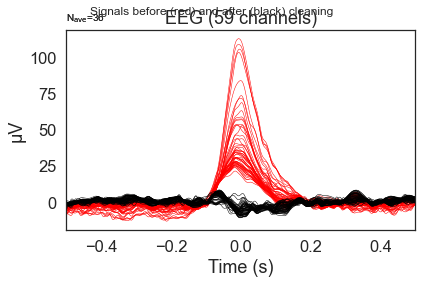

In [12]:
ica.plot_overlay(eog_average, exclude=eog_inds, show=False);

To register this component as a bad one to be remove, use the `ica.exclude` attribute. This is a simple Python list.

In [13]:
ica.exclude.extend(eog_inds)

Note that nothing is yet removed from the raw data. To remove the effects of the rejected components, the apply method must be called. We apply the ICA transformation to a copy of the original raw data.

In [14]:
# Copy filtered raw data
data_ica = data_filtered.copy()

# Apply ICA decomposition and transformation
ica.apply(data_ica)

# Save preprocessed data
ica_fn = '../eeg-data/sub-01_task-audvis_preproc_raw.fif'
data_ica.save(ica_fn, overwrite=True)

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components
Overwriting existing file.
Writing /Users/snastase/Work/neu502b/demos/eeg-01/../eeg-data/sub-01_task-audvis_preproc_raw.fif
Closing /Users/snastase/Work/neu502b/demos/eeg-01/../eeg-data/sub-01_task-audvis_preproc_raw.fif
[done]
